## Explortory Data Analysis

EDAは次のサイクルによって行われる探索的データ分析手法である. 

- Generate questions about your data
- Search for answers by visualizing, transforming, and modeling our data
- User what you learn to refine your questions and/or generate new questions

EDAを進めるのに定石はない. しかし,　次の二つの質問から始めるとよい質問にたどり着くことがある. 

1. What type of variation occurs within my variables?
2. What type of covariation occurs between my variables?



In [43]:
library (tidyverse)
library (gridExtra)
library (ggstance)
library (modelr)

### Visualizing Distributions

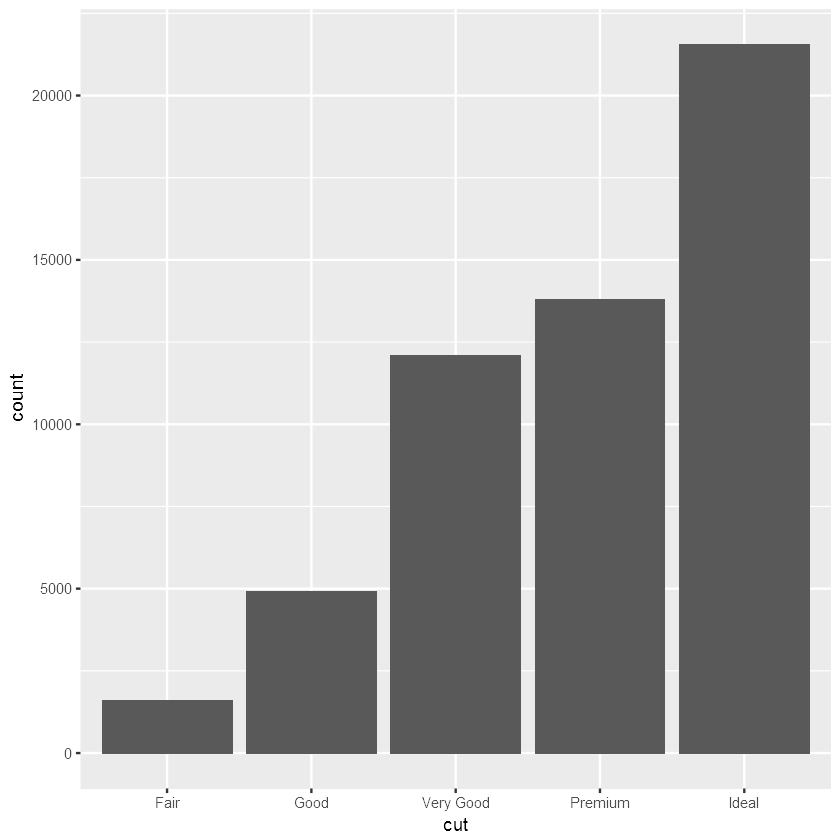

In [2]:
## カテゴリカルデータに、順序があるならば、分布を作成
ggplot(data=diamonds) + 
    geom_bar (mapping = aes(x = cut))

# A tibble: 11 × 2
      cut_level     n
         <fctr> <int>
1  [-0.25,0.25]   785
2   (0.25,0.75] 29498
3   (0.75,1.25] 15977
4   (1.25,1.75]  5313
5   (1.75,2.25]  2002
6   (2.25,2.75]   322
7   (2.75,3.25]    32
8   (3.25,3.75]     5
9   (3.75,4.25]     4
10  (4.25,4.75]     1
11  (4.75,5.25]     1


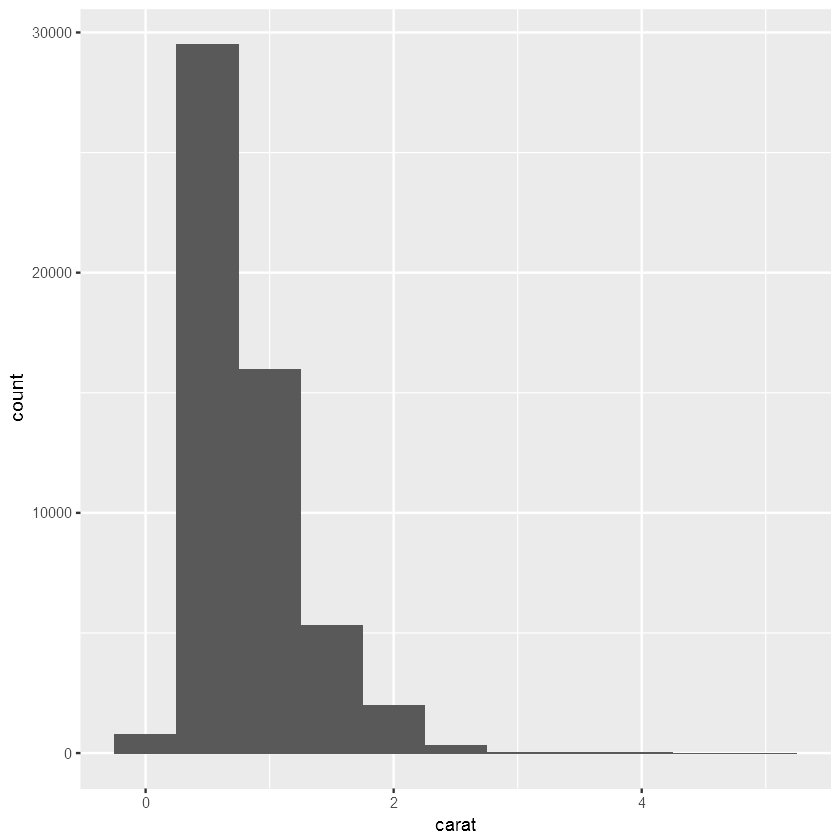

In [8]:
## 連続値にはヒストグラムで可視化をおこなう
## ヒストグラムは, 瓶の大きさで見た目が変わるので,いくつか試してみよう
ggplot(data=diamonds)+ 
    geom_histogram(mapping = aes(x= carat), binwidth = .5)

## ちなみにヒストグラムで描画している値は次のようにして確認
diamonds %>%
    count (cut_level = cut_width(carat, .5)) %>%
    print()

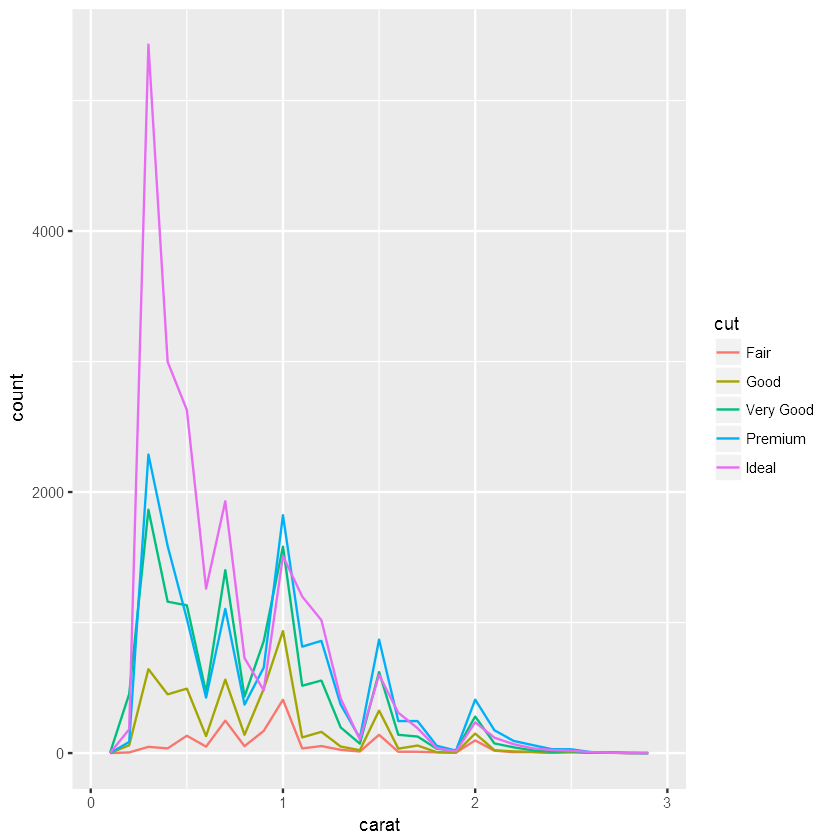

In [9]:
## ヒストグラムを複数重ねたいばあいには, freqpolyを利用しよう
smaller <- diamonds %>% filter (carat < 3)
smaller %>%
    ggplot(aes(x=carat, color=cut)) + 
    geom_freqpoly(binwidth = .1)

ここまでのグラフでも, いくつか疑問がわいてくる. 

- Why are there more diamonds at whole carats and common fraction of carats?
- Why are there more diamonds slightly to the right of each peak than there are slightly to the left of each peak?
- Why are there no diamonds bigger than 3carats?

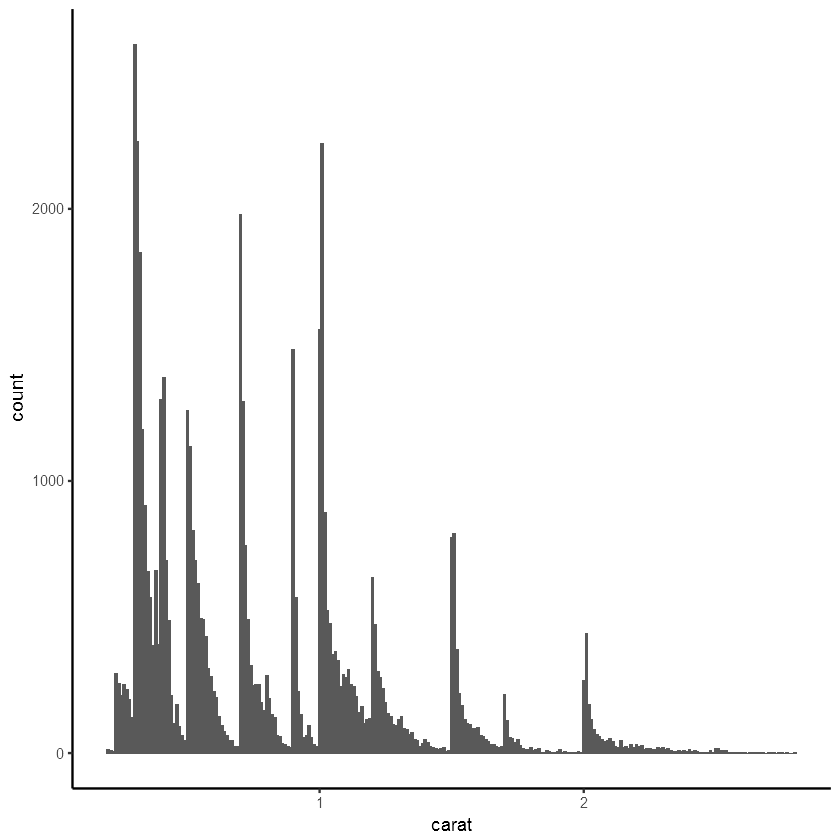

In [12]:
ggplot(smaller, aes(x=carat)) + 
    geom_histogram(binwidth = .01) + 
    theme_classic()

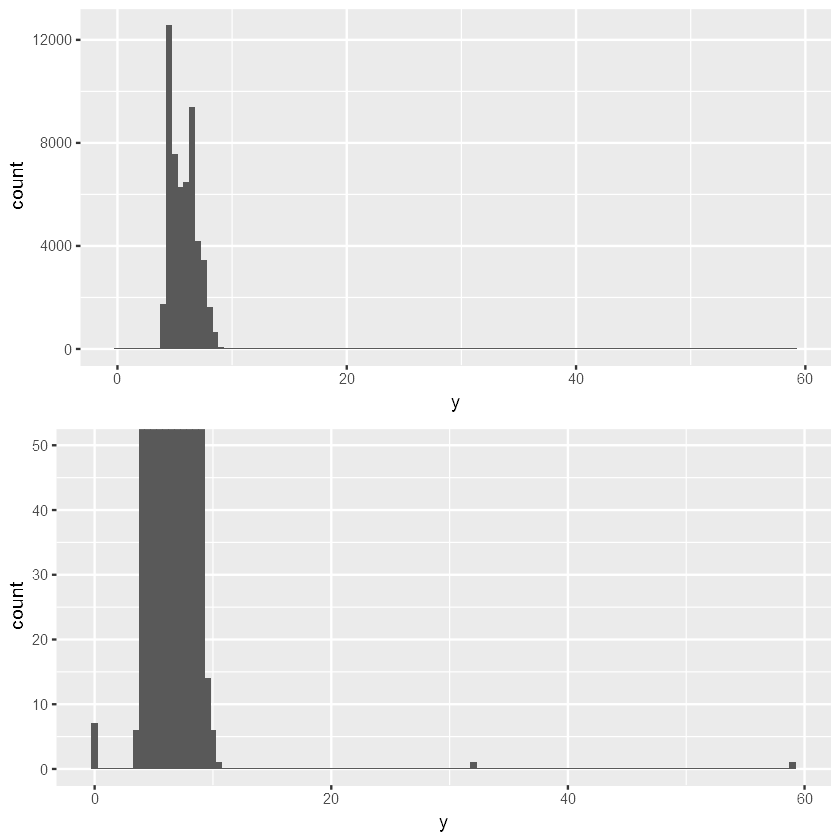

In [18]:
## ヒストグラムは、データが多い場合には異常値を見つけ憎い
## y軸方向を制限するのもあり
grid.arrange (
    #　そのままプロット
    ggplot(diamonds) + geom_histogram(mapping = aes(x=y), binwidth=.5), 
    
    # y軸を制限
    ggplot(diamonds) + geom_histogram(mapping = aes(x=y), binwidth=.5) + 
    coord_cartesian(ylim=c(0, 50))
)

### Missing value

異常値に出くわした場合には, 二つの方法がある. データを除外するのか, 欠測値として扱うのかだ. 
一般的には前者は観測地を削除することとなるため推奨されない. 

In [19]:
## 範囲外の値については, 欠測値として扱う
diamonds2 <- diamonds %>%
    mutate (y = ifelse (y < 3 | y > 20 , NA, y))

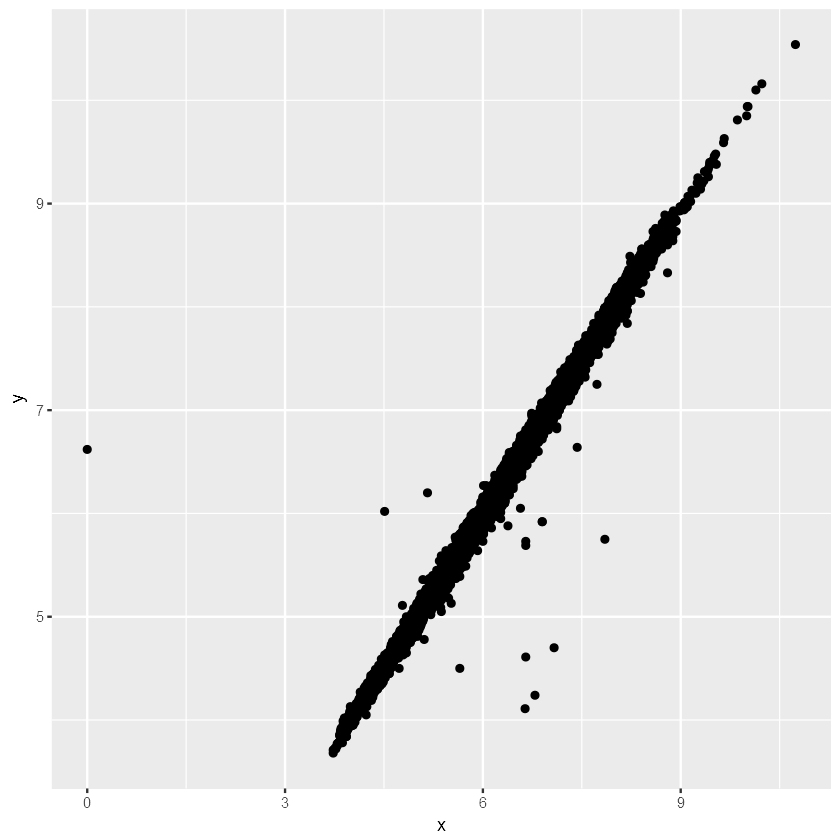

In [21]:
## ggplot2では、NAだと描画されない
ggplot(data=diamonds2, mapping =aes(x=x, y=y)) + 
    geom_point(na.rm=TRUE)

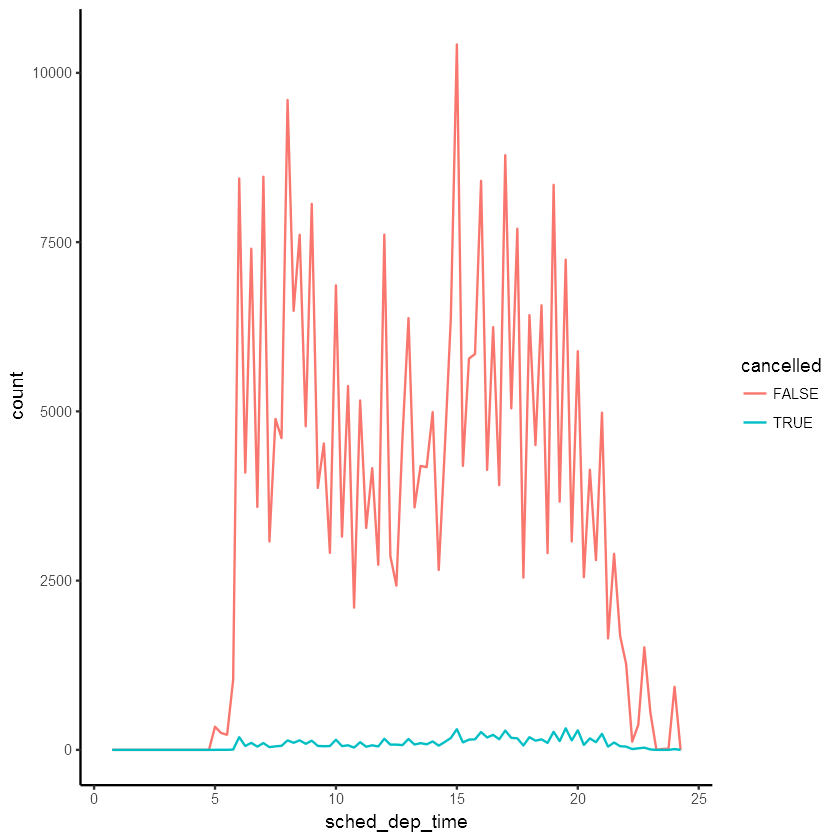

In [27]:
## 欠測値があると、どのような条件で欠測値があるのかが検討したくなる
## 次の例では時間帯でフライトがキャンセルされているかを確認する、ヒストグラムを作成している
nycflights13::flights %>%
    mutate (
        cancelled      = is.na(dep_time), 
        sched_hour     = sched_dep_time %/% 100, 
        sched_min      = sched_dep_time %% 100, 
        sched_dep_time = sched_hour + sched_min / 60
    ) %>%
    ggplot(mapping = aes(sched_dep_time)) + 
        geom_freqpoly (
            mapping = aes(color = cancelled), 
            binwidth = 1/4
        ) + 
        theme_classic()

### A Categoriacal and Continuouse Variable

頻度分布を比較する際, データ数が大きく異なるとカテゴリーごとの形状の比較が難しくなる. 
そこで, 密度グラフするという手段をとることができる.


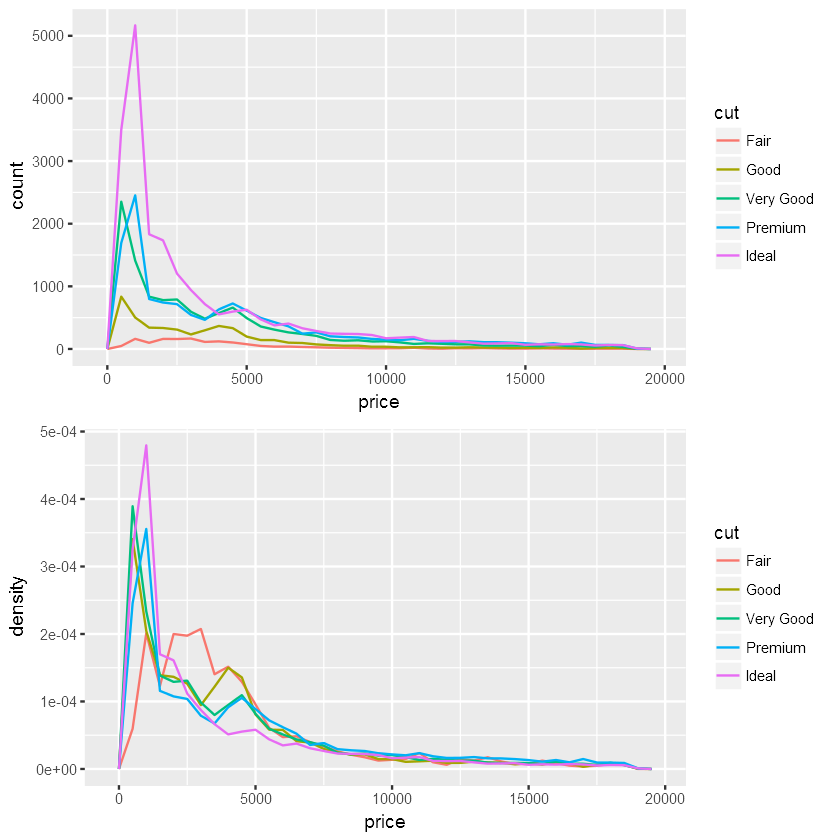

In [4]:
grid.arrange(
    ggplot(diamonds, aes(x=price)) + geom_freqpoly(aes(color=cut), binwidth=500), 
    ggplot(diamonds, aes(x=price)) + geom_freqpoly(aes(y = ..density.., color=cut), binwidth=500) 
)

reorder関数を使えば, カテゴリかるなx軸を並び変えることが可能である. また, coord_flipを使えば, x軸とy軸を反転することが可能である. 

Warning message:
"position_dodgev requires non-overlapping y intervals"

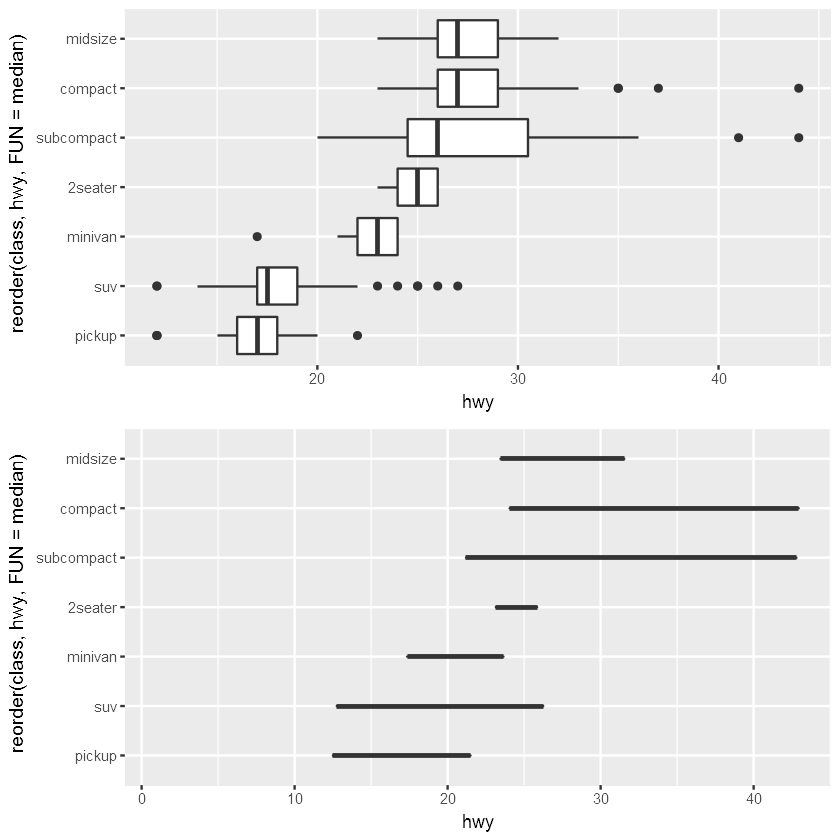

In [21]:
grid.arrange (
    ggplot(data=mpg, mapping=aes(x=reorder(class, hwy, FUN=median) , y=hwy)) +
    geom_boxplot() + 
    coord_flip(), 
    ggplot(data=mpg, mapping=aes(x=reorder(class, hwy, FUN=median) , y=hwy)) +
    geom_boxploth() + 
    coord_flip()
)

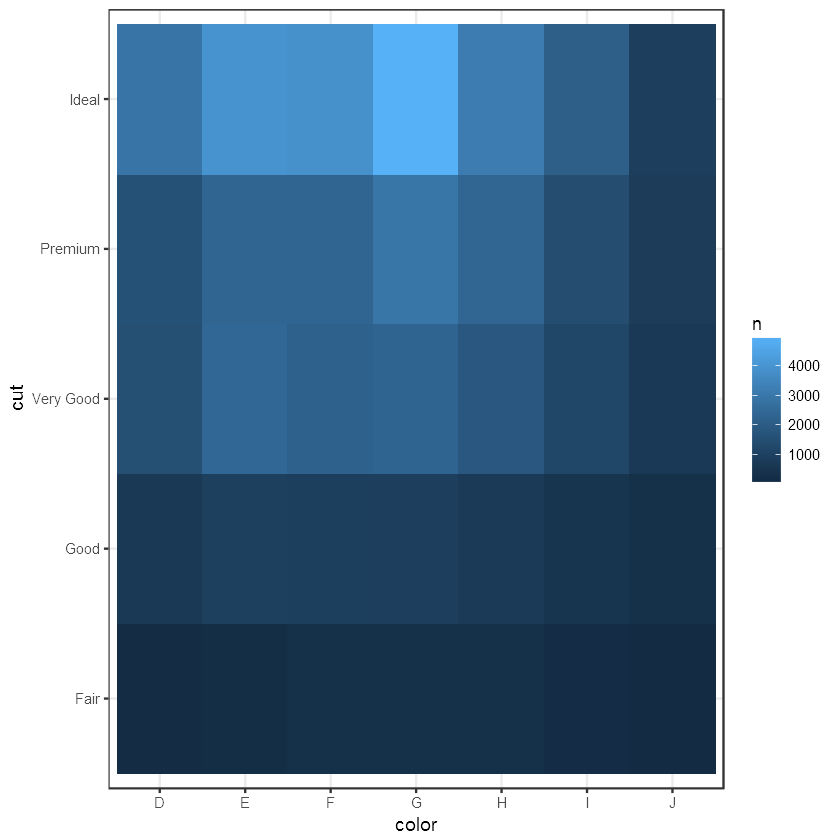

In [31]:
# ヒートマップを作成してみる
diamonds %>% 
    count(color, cut) %>%
    ggplot(mapping = aes(x = color, y = cut)) + 
    geom_tile(mapping = aes(fill=n)) + 
    theme_bw()

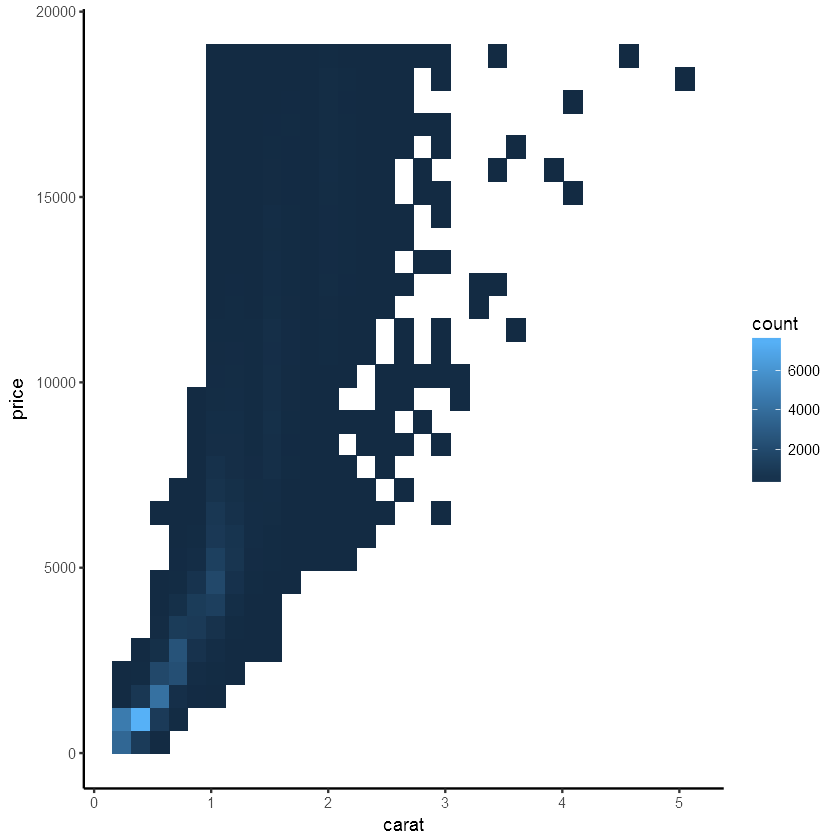

In [35]:
## 散布図はデータ数が多くなると、とても理解しずらい
## そこで、二次元ヒストグラムを作成することも可能である
ggplot(data=diamonds) + 
    geom_bin2d(mapping=aes(x=carat, y=price)) + 
    theme_classic()

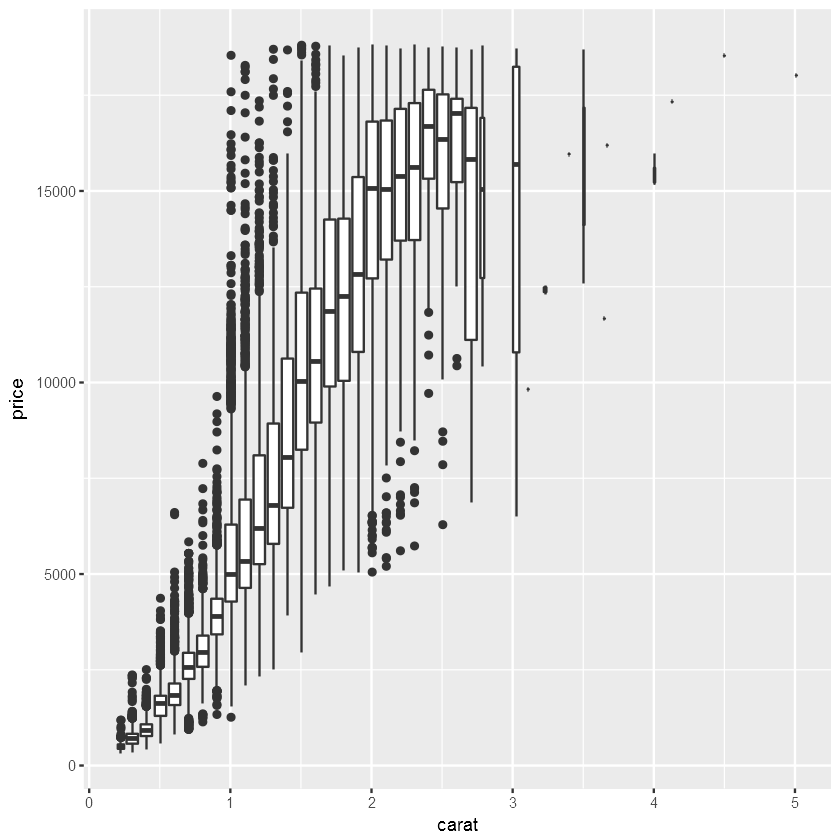

In [37]:
## もしくは,　実数をカテゴライズしてしまう手がある
ggplot(data=diamonds, mapping =aes(x=carat, y=price)) +
    geom_boxplot(mapping=aes(group=cut_width(carat, .1)))

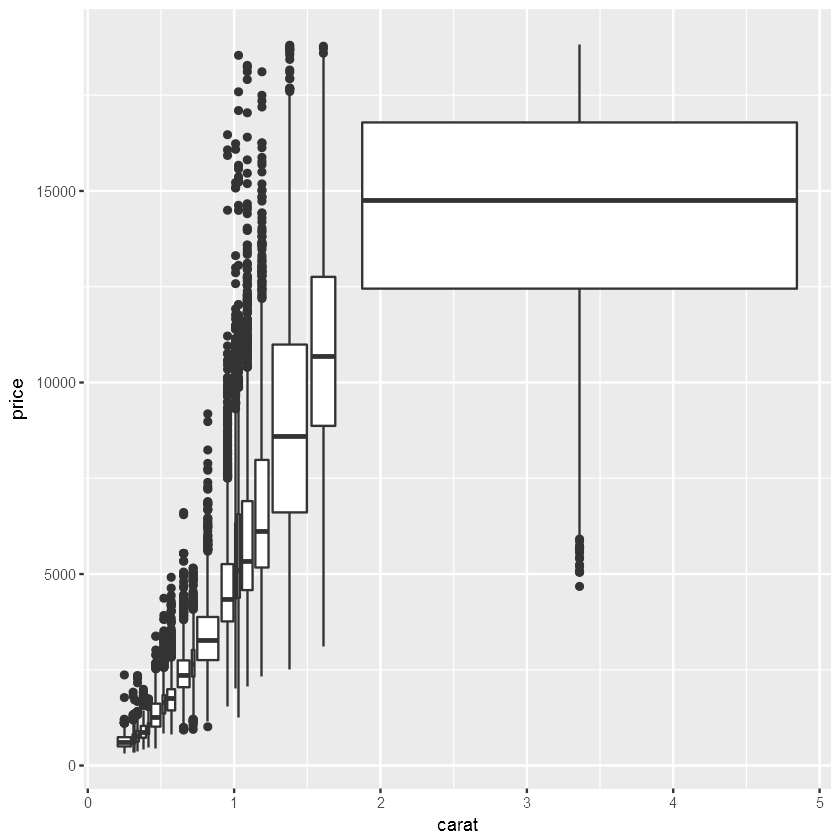

In [39]:
# ただし, この方法だと各ボックスがどの程度のデータ数をまとめる
# こととなっているか判断しずらい.
# そこで, 次の方法である. 

diamonds %>%
    ggplot(mapping = aes(x=carat, y = price)) + 
    geom_boxplot(mapping = aes(group= cut_number(carat, 20)))




### Patterns and Models

複雑なデータはモデリングしてパターンを抽出することが重要である. また, モデルを利用して特定の変数の影響を除去することも有効である. 次の例では線形モデルの残さを見ることで, caratの影響を除した変数間の関係を見ている.



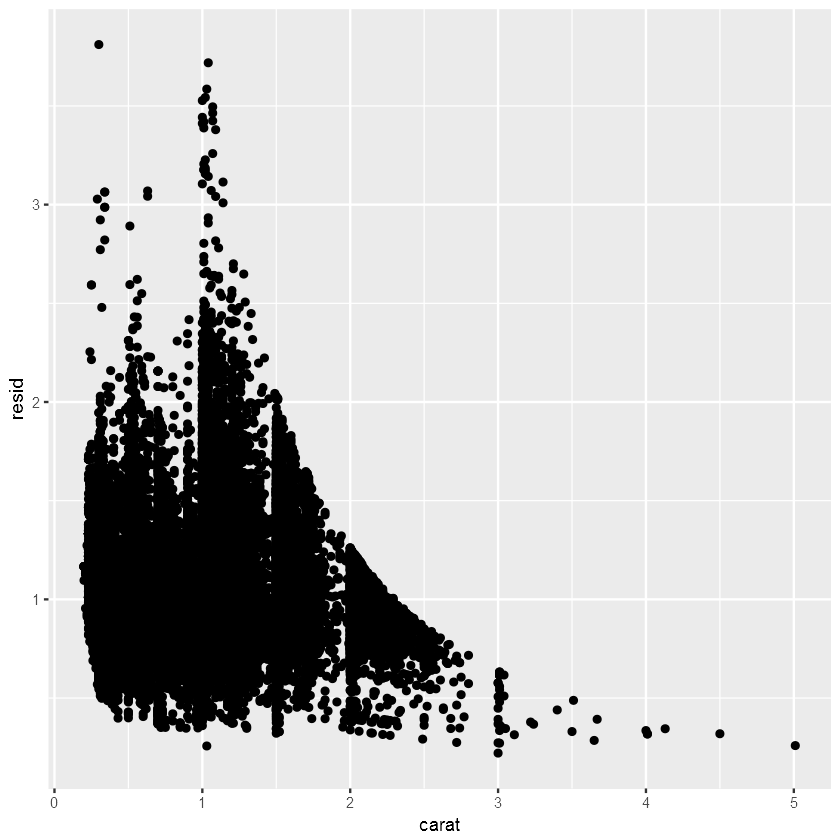

In [49]:
mod <- lm (log(price) ~ log(carat), data = diamonds)

diamonds2 <- 
    diamonds %>%
    add_residuals(mod) %>%
    mutate (resid = exp (resid))

diamonds2 %>%
    ggplot() + 
    geom_point(mapping = aes(x = carat, y = resid))


ggplot2については[こちら](http://ggplot2.org/book)を確認しよう. 